In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
import itertools
import seaborn as sn
from sklearn.decomposition import PCA;
from datetime import datetime

c:\users\nand chandravadia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\users\nand chandravadia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://num

In [2]:
def extract_data(file, header, index_col, dtype, converters, skiprows, parse_dates,date_parser):

    '''
    Purpose:
        -Extracts data from Excel File and imports as Pandas DataFrame
    Inputs:
        -file: path to excel file (.csv)
    Outputs:
        -
    '''

    #Read CSV File
    data = pd.read_csv(filepath_or_buffer = file, header = header, index_col = index_col, dtype = dtype, converters= converters,
                       skiprows = skiprows, parse_dates = parse_dates, date_parser=dateparse)
    #Resort By Date
    #data_resorted = data.sort_values(by=['Date'])

    return data

In [3]:
#read $SPX data, and model data 

#read BTC file
SPX_file = "./data/total_chain_spx.csv"

f = lambda x : float(x)
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
converters_data = {'strike': f, 'last': f, 'bid': f, 'ask': f, 
                       'volume': f}


pd_SPX = extract_data(file = SPX_file, header = 0, index_col = 8, dtype = None, converters = converters_data, skiprows = None, 
                            parse_dates = False, date_parser=dateparse)# .sort_values(by=['quotedate'])

In [4]:
total_chain = pd.read_csv('./data/total_chain_spx.csv')

In [5]:
pd_SPX = total_chain.set_index('quotedate')

In [47]:
#apply log to SPX price 

pd_SPX['underlying_last_log10'] = np.log10(pd_SPX['underlying_last'])

In [6]:
#upload pre-computed data

all_smoothed = np.load('all_smoothed.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII');
deltaSurf = np.load('dsurf.npy', mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII');

In [7]:
def compute_A(surface): 
    
    sfc = surface.copy()

    return list(itertools.product(sfc[: 0],sfc[:, 1]))

In [8]:
U = deltaSurf[0][0]

In [9]:
def compute_covariance(delta_impliedvol):
    
    covariance_all = []
    comb = list(itertools.combinations(delta_impliedvol,2))
    
    for i in comb: 
        
        cov = np.cov(np.array(i))
        covariance_all.append(cov)
    
    return covariance_all

In [10]:
def KLT(a):
    """
    Returns Karhunen Loeve Transform of the input and the transformation matrix and eigenval
    
    Ex:
    import numpy as np
    a  = np.array([[1,2,4],[2,3,10]])
    
    kk,m = KLT(a)
    print kk
    print m
    
    # to check, the following should return the original a
    print np.dot(kk.T,m).T
        
    """
    val,vec = np.linalg.eig(np.cov(a))
    klt = np.dot(vec,a)
    return klt,vec,val

c:\users\nand chandravadia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:28: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


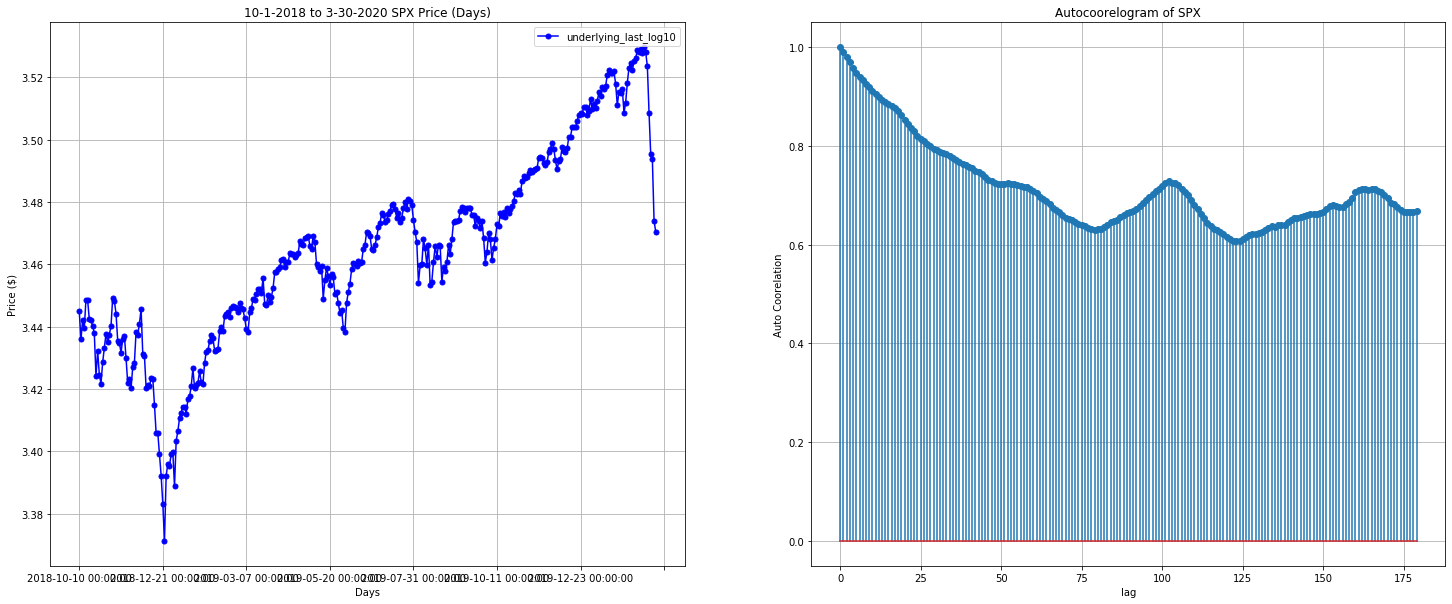

In [50]:
# plot spx price with autocoorelogram

fig, axes = plt.subplots(1, 2, figsize = (25, 10)) 

pd_SPX_remove_dupicates = pd_SPX.drop_duplicates(subset='underlying_last', keep='first', inplace=False)


year_start, year_end = '2018', '2020'
month_start, month_end = '10', '3'
day_start, day_end = '1', '30'
minute_start, minute_end = '00:00:00', '00:00:00' #military time


time_start = "{}-{}-{} {}".format(year_start, month_start, day_start, minute_start)
time_end = "{}-{}-{} {}".format(year_end, month_end, day_end, minute_end)

spx = pd_SPX_remove_dupicates.loc[time_start:time_end]
spx.plot(y = 'underlying_last_log10', ax = axes[0], sharex= True, figsize = (25,10), 
        grid = True, xlabel = "Days", ylabel = "Price ($)", 
        title = "{}-{}-{} to {}-{}-{} SPX Price (Days)".format(month_start, day_start, year_start, month_end, day_end, year_end), 
        color = 'blue', markersize = 5, marker = 'o')



 #compute autocoorelation 
lag = 30*6
autocorr = [spx['underlying_last_log10'].autocorr(lag=i) for i in range(0, lag)] 
axes[1].stem(range(0, len(autocorr)), autocorr)
axes[1].set_title('Autocoorelogram of SPX')
axes[1].set_xlabel('lag')
axes[1].set_ylabel('Auto Coorelation')
axes[1].grid(True)




c:\users\nand chandravadia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


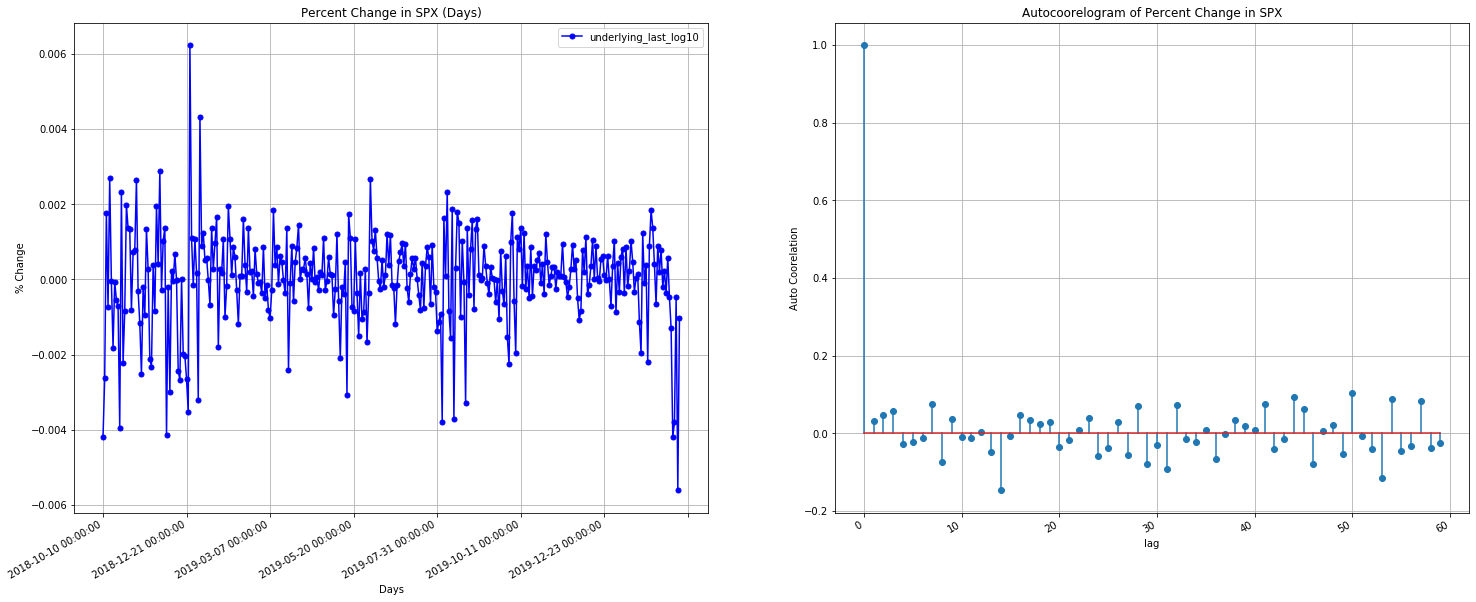

In [56]:
# plot percent change spx price with autocoorelogram


spx_pct_change = pd_SPX_remove_dupicates['underlying_last_log10'].pct_change().to_frame()

fig, axes = plt.subplots(1, 2, figsize = (25, 10)) 


year_start, year_end = '2018', '2020'
month_start, month_end = '10', '3'
day_start, day_end = '1', '30'
minute_start, minute_end = '00:00:00', '00:00:00' #military time


time_start = "{}-{}-{} {}".format(year_start, month_start, day_start, minute_start)
time_end = "{}-{}-{} {}".format(year_end, month_end, day_end, minute_end)

spx_percent_change_range = spx_pct_change.loc[time_start:time_end]
spx_percent_change_range.plot(y = 'underlying_last_log10', ax = axes[0], sharex= True, figsize = (25,10), 
        grid = True, xlabel = "Days", ylabel = "% Change", 
        title = "Percent Change in SPX (Days)", 
        color = 'blue', markersize = 5, marker = 'o')
fig.autofmt_xdate()



 #compute autocoorelation 
lag = 30*2
autocorr = [spx_percent_change_range['underlying_last_log10'].autocorr(lag=i) for i in range(0, lag)] 
axes[1].stem(range(0, len(autocorr)), autocorr)
axes[1].set_title('Autocoorelogram of Percent Change in SPX')
axes[1].set_xlabel('lag')
axes[1].set_ylabel('Auto Coorelation')
axes[1].grid(True)



In [57]:
#for each day compute the percent change in variance 

data = {}
data['date'] = []
data['explained_variance_pc1'] = []
data['explained_variance_pc2'] = []
data['explained_variance_pc3'] = []

for delt in deltaSurf: 
    
    pca = PCA(n_components=3)
    pca.fit(delt[0])
    
    data['date'].append(delt[1])
    data['explained_variance_pc1'].append(pca.explained_variance_ratio_[0])
    data['explained_variance_pc2'].append(pca.explained_variance_ratio_[1])
    data['explained_variance_pc3'].append(pca.explained_variance_ratio_[2])
    
pc = pd.DataFrame(data)
pc = pc.set_index('date')

array([0.34802749, 0.05631246, 0.00119418])

c:\users\nand chandravadia\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\users\nand chandravadia\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\nand chandravadia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


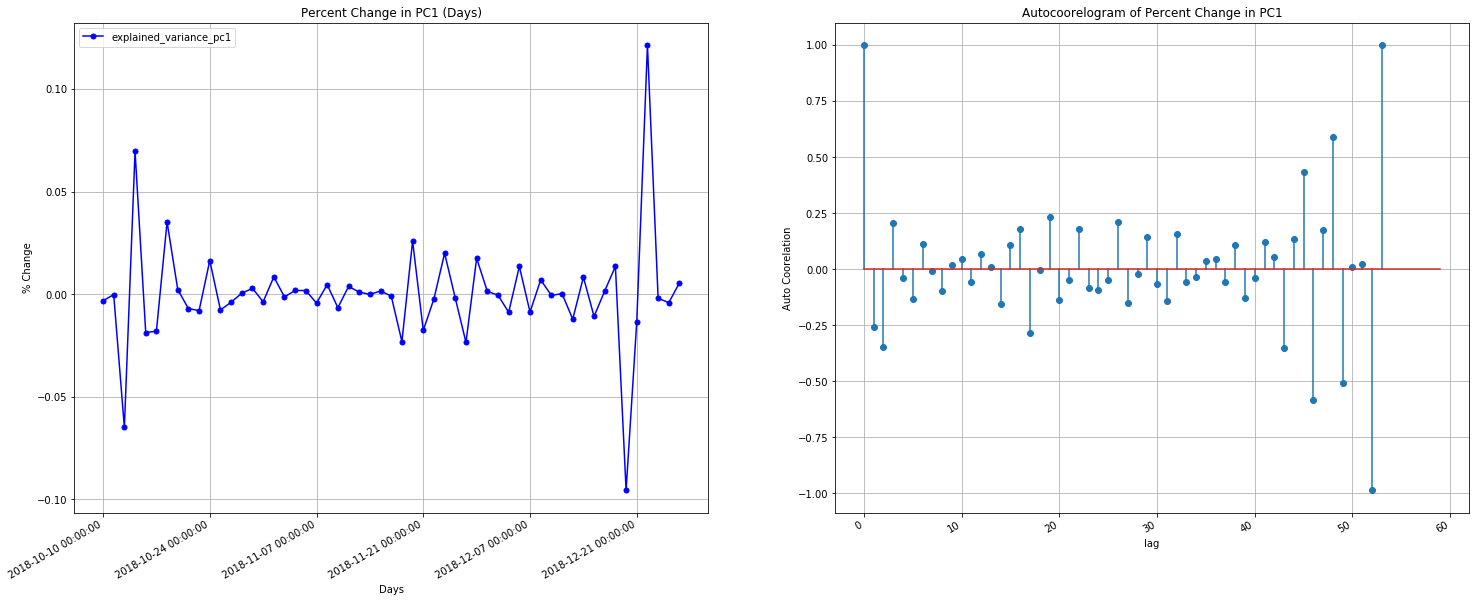

In [58]:
#look at percent change in principal components

which_pc = 1 #specifiy the principal component

pc_percent_change = pc.pct_change()

fig, axes = plt.subplots(1, 2, figsize = (25, 10)) 


year_start, year_end = '2018', '2018'
month_start, month_end = '10', '12'
day_start, day_end = '1', '30'
minute_start, minute_end = '00:00:00', '00:00:00' #military time


time_start = "{}-{}-{} {}".format(year_start, month_start, day_start, minute_start)
time_end = "{}-{}-{} {}".format(year_end, month_end, day_end, minute_end)

pc_percent_change_range = pc_percent_change.loc[time_start:time_end]
pc_percent_change_range.plot(y = 'explained_variance_pc{}'.format(which_pc), ax = axes[0], sharex= True, figsize = (25,10), 
        grid = True, xlabel = "Days", ylabel = "% Change", 
        title = "Percent Change in PC{} (Days)".format(which_pc), 
        color = 'blue', markersize = 5, marker = 'o')
fig.autofmt_xdate()



 #compute autocoorelation 
lag = 30*2
autocorr = [pc_percent_change_range['explained_variance_pc{}'.format(which_pc)].autocorr(lag=i) for i in range(0, lag)] 
axes[1].stem(range(0, len(autocorr)), autocorr)
axes[1].set_title('Autocoorelogram of Percent Change in PC{}'.format(which_pc))
axes[1].set_xlabel('lag')
axes[1].set_ylabel('Auto Coorelation')
axes[1].grid(True)



Text(0.5, 1.0, 'Cross - Coorelation: {}')

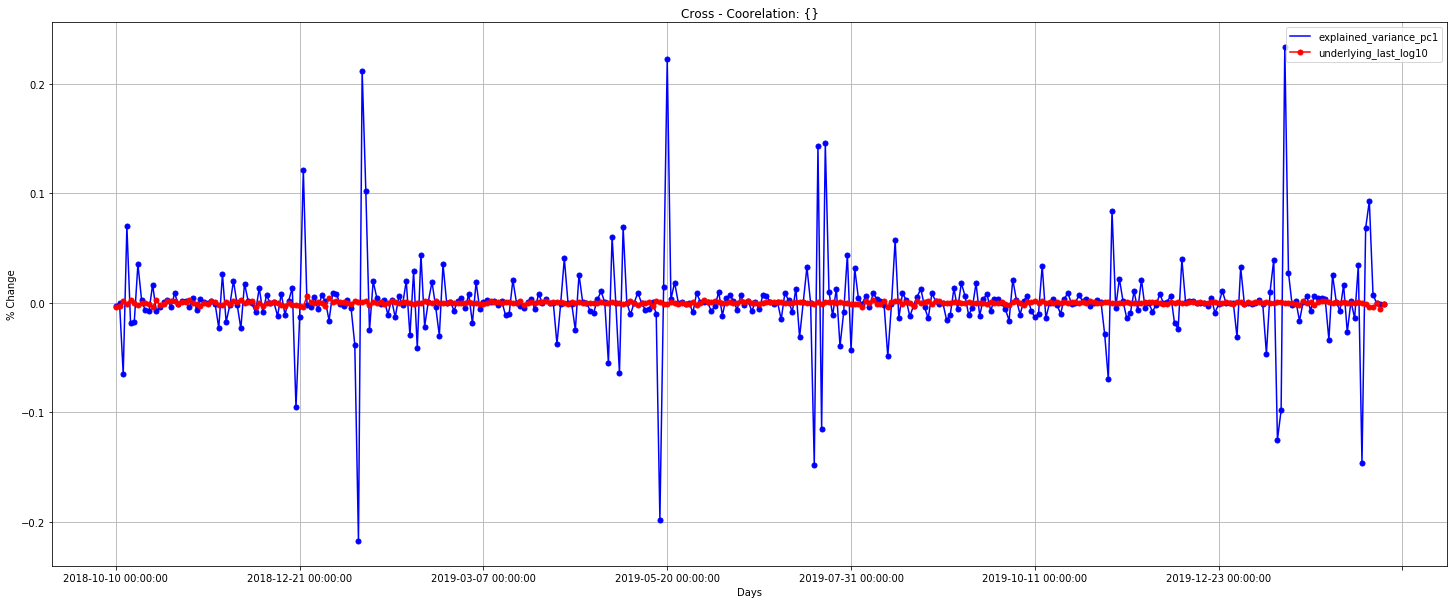

In [59]:
#look at cross-coorelation of percent change in spx and percent change in pc's

fig, axes = plt.subplots(1, 1, figsize = (25, 10)) 

which_pc = 1

year_start, year_end = '2018', '2020'
month_start, month_end = '10', '3'
day_start, day_end = '1', '31'
minute_start, minute_end = '00:00:00', '00:00:00' #military time


time_start = "{}-{}-{} {}".format(year_start, month_start, day_start, minute_start)
time_end = "{}-{}-{} {}".format(year_end, month_end, day_end, minute_end)

combine_spx_pc = pd.concat([spx_pct_change,pc_percent_change], axis=1, join='inner')

combine_spx_pc_range = combine_spx_pc.loc[time_start:time_end]

combine_spx_pc_range.plot(y = 'explained_variance_pc{}'.format(which_pc), ax = axes, sharex= True, figsize = (25,10), 
        grid = True, xlabel = "Days", ylabel = "% Change", 
        color = 'blue', markersize = 5, marker = 'o')


combine_spx_pc_range.plot(y = 'underlying_last_log10', ax = axes, sharex= True, figsize = (25,10), 
        grid = True, xlabel = "Days", ylabel = "% Change", 
        color = 'red', markersize = 5, marker = 'o')


axes.set_title('Cross - Coorelation: {}')

In [65]:
combine_spx_pc_range['2018-10-01 00:00:00': '2018-10-30 00:00:00'].corr()

,underlying_last_log10,explained_variance_pc1,explained_variance_pc2,explained_variance_pc3
underlying_last_log10,1.000000,-0.381734,0.374754,-0.225792
explained_variance_pc1,-0.381734,1.000000,-0.934966,-0.299377
explained_variance_pc2,0.374754,-0.934966,1.000000,0.100332
explained_variance_pc3,-0.225792,-0.299377,0.100332,1.000000


In [66]:
combine_spx_pc_range['2018-11-01 00:00:00': '2018-11-30 00:00:00'].corr()

,underlying_last_log10,explained_variance_pc1,explained_variance_pc2,explained_variance_pc3
underlying_last_log10,1.000000,-0.130074,0.242045,0.115332
explained_variance_pc1,-0.130074,1.000000,-0.679099,-0.621142
explained_variance_pc2,0.242045,-0.679099,1.000000,0.333549
explained_variance_pc3,0.115332,-0.621142,0.333549,1.000000


In [67]:
combine_spx_pc_range['2018-12-01 00:00:00': '2018-12-30 00:00:00'].corr()

,underlying_last_log10,explained_variance_pc1,explained_variance_pc2,explained_variance_pc3
underlying_last_log10,1.000000,-0.102961,0.102317,-0.174231
explained_variance_pc1,-0.102961,1.000000,-0.913580,-0.684683
explained_variance_pc2,0.102317,-0.913580,1.000000,0.515971
explained_variance_pc3,-0.174231,-0.684683,0.515971,1.000000


In [70]:
combine_spx_pc_range['2019-01-01 00:00:00': '2019-01-30 00:00:00'].corr()

,underlying_last_log10,explained_variance_pc1,explained_variance_pc2,explained_variance_pc3
underlying_last_log10,1.000000,0.111338,-0.065331,0.148172
explained_variance_pc1,0.111338,1.000000,-0.899332,-0.249345
explained_variance_pc2,-0.065331,-0.899332,1.000000,0.015272
explained_variance_pc3,0.148172,-0.249345,0.015272,1.000000
